In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Importing Libraries

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import mutual_info_regression

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas_profiling

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Reading training set

In [3]:
df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv',index_col=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 80)

Shape of the Dataset is (1460,80)

**Making sure that Target Value is available for each instance**

In [5]:
df.SalePrice.isnull().sum() #Target Value is available for each instance

0

In [6]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

*minimum sale price is greater than zero and none of the Saleprice is missing. Good for our model*

# Exploratory Data Analysis

### Analysing SalePrice

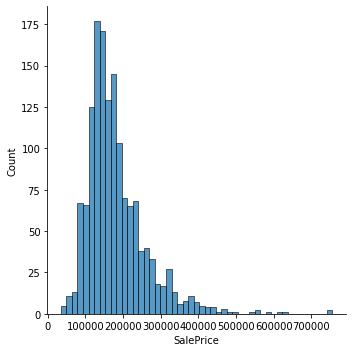

In [7]:
sns.displot(df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

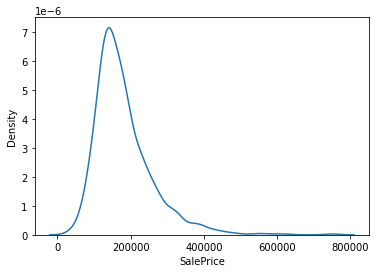

In [8]:
sns.kdeplot(df.SalePrice)

SalePrice is right skewed as mean>median>mode with mean value of 180921.2

**Skewness of SalePrice**

In [9]:
df.SalePrice.skew()

1.8828757597682129

In [10]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

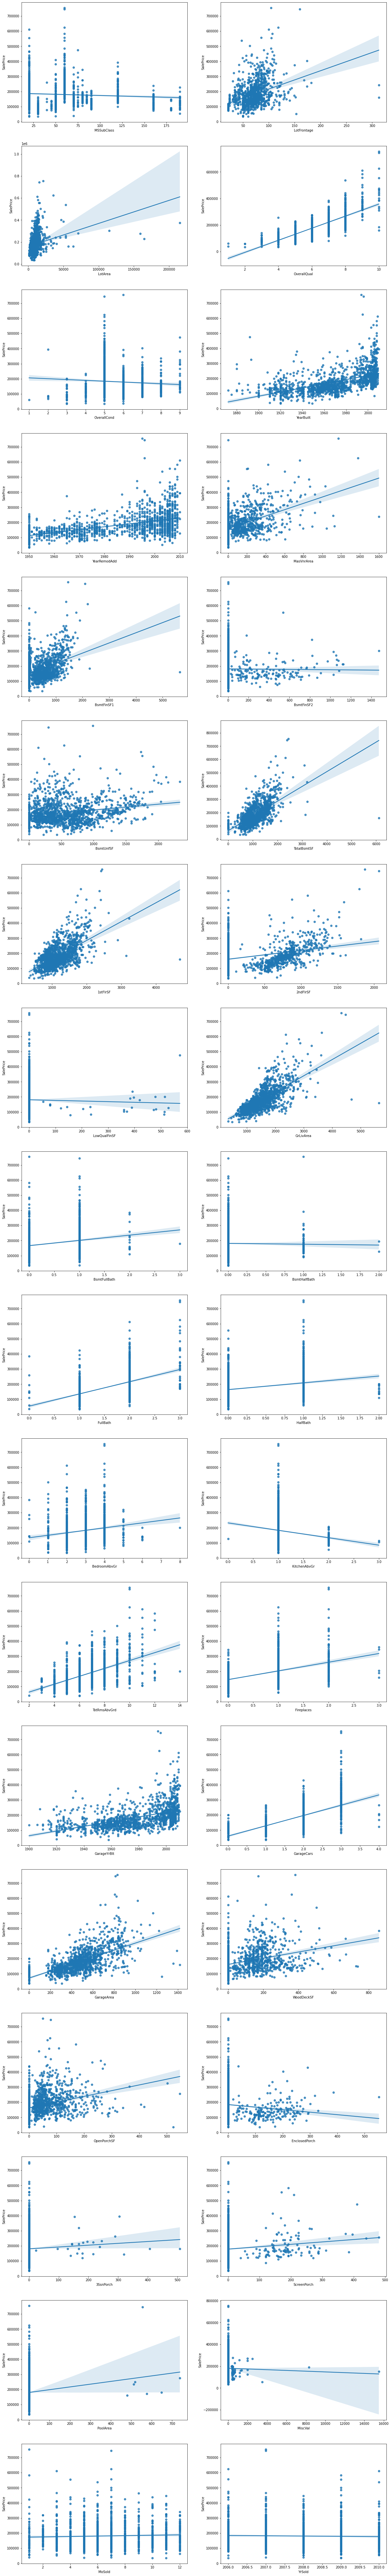

In [11]:
numerical_columns=list(df.select_dtypes(exclude='object').columns)

numerical_columns.remove('SalePrice')



plt.figure(figsize=(20,len(numerical_columns)*4))
for i in range(len(numerical_columns)):
    plt.subplot(int(len(numerical_columns)/2),2,i+1)
    sns.regplot(x=numerical_columns[i],y='SalePrice',data=df)

**Insights:**
1. 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', and 'GarageArea' shows strong relation with 'SalePrice
2. MSSubClass', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtHalfBath', 'MiscVal', 'MoSold', and 'YrSold' does not shows any significant relation with SalePrice

In [12]:
object_columns=list(df.select_dtypes(include=object).columns)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 61.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

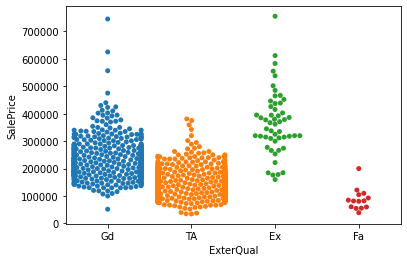

In [13]:
sns.swarmplot(x='ExterQual',y='SalePrice',data=df)

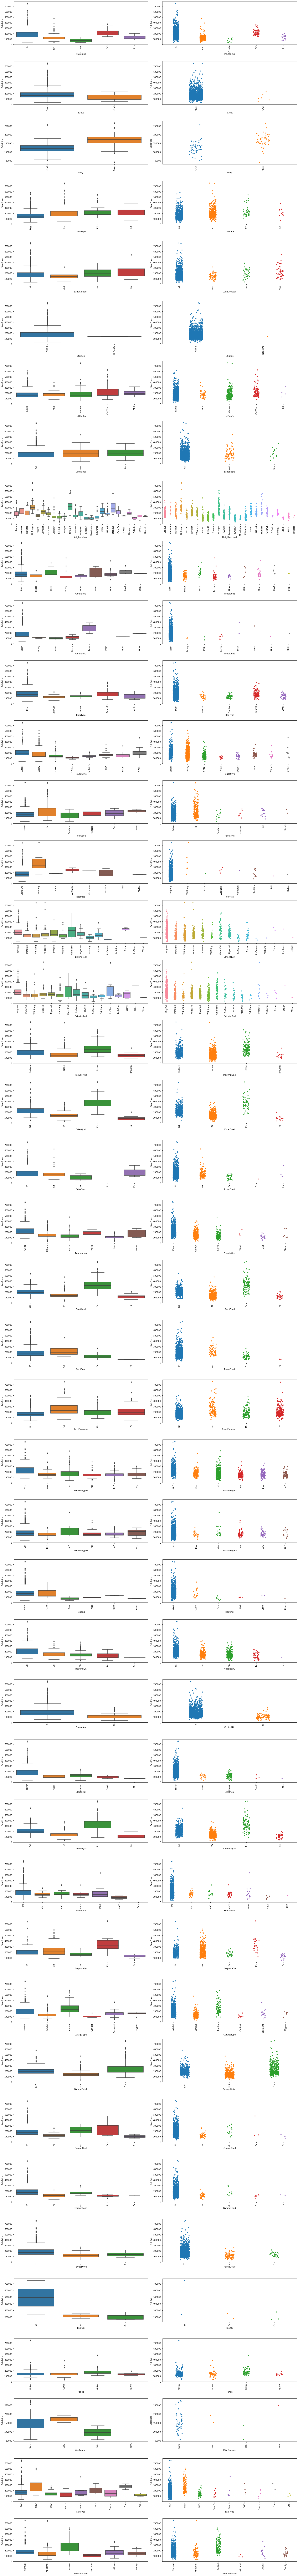

In [14]:
plt.figure(figsize=(20,len(object_columns)*4))
j=0
for cname in object_columns:
    j+=1
    plt.subplot(len(object_columns),2,j)
    sns.boxplot(x=cname,y='SalePrice',data=df)
    plt.xticks(rotation=90)
    j+=1
    plt.subplot(len(object_columns),2,j)
    sns.stripplot(x=cname,y='SalePrice',data=df)
    plt.xticks(rotation=90)
    plt.xlabel(cname)
    plt.tight_layout()

Insights:
1. Pave - Street & Alley have higher SalePrice than Gravel
2. Excellent Conditions have higher SalePrice than Good/Fair/Poor
3. Houses with Concrete Foundations, Central Air, excellent Heating quality are costly


In [15]:
#pandas_profiling.ProfileReport(df)

In [16]:
X_train=df.drop(['SalePrice'],axis=1)
y_train=df.SalePrice

In [17]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,train_size=0.8,test_size=0.2)

# Reading Test set

In [18]:
X_test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv',index_col=0)
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [19]:
X_train.shape

(1460, 79)

In [20]:
X_test.shape

(1459, 79)

# **Handling Missing Values - Part1**

*for those variable for which the value is not applicable. for example, there is No Garage, No Fireplace, No Basement,etc*

In [21]:
X_train.isnull().sum().sort_values(ascending=False)[:15]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageCond        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtFinType1      37
dtype: int64

In [22]:
X_train[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType2','BsmtExposure','BsmtCond','BsmtFinType1','BsmtQual']]=X_train[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType2','BsmtExposure','BsmtCond','BsmtFinType1','BsmtQual']].fillna('NA')

In [23]:
X_test.isnull().sum().sort_values(ascending=False)[:15]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
dtype: int64

In [24]:
X_test[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType2','BsmtExposure','BsmtCond','BsmtFinType1','BsmtQual']]=X_test[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtFinType2','BsmtExposure','BsmtCond','BsmtFinType1','BsmtQual']].fillna('NA')

# Adding New Features

In [25]:
X_train['AgeBuilt']=X_train.YrSold-X_train.YearBuilt
X_train['AgeRemodAdd']=X_train.YrSold-X_train.YearRemodAdd

X_test['AgeBuilt']=X_test.YrSold-X_test.YearBuilt
X_test['AgeRemodAdd']=X_test.YrSold-X_test.YearRemodAdd

X_train['AgeGarage']=X_train.YrSold-X_train.GarageYrBlt
X_test['AgeGarage']=X_test.YrSold-X_test.GarageYrBlt

In [26]:
X_train.drop(['GarageYrBlt','YrSold','MoSold','YearBuilt','YearRemodAdd'],axis=1,inplace=True)
X_test.drop(['GarageYrBlt','YrSold','MoSold','YearBuilt','YearRemodAdd'],axis=1,inplace=True)

# **Handling missing Values - Part 2**

In [27]:
X_train.AgeGarage=X_train.AgeGarage.fillna(0)
X_test.AgeGarage=X_test.AgeGarage.fillna(0)

In [28]:
numerical_col=X_train.select_dtypes(include='number').columns

*strategy = mean for numerical columns*

In [29]:
myImputer=SimpleImputer()
X_train[numerical_col]=myImputer.fit_transform(X_train[numerical_col])

X_test[numerical_col]=myImputer.transform(X_test[numerical_col])

strategy = most_frequent for categorical columns

In [30]:
object_col=[cname for cname in X_train.columns if X_train[cname].dtype==object]

In [31]:
my_Second_Imputer=SimpleImputer(strategy='most_frequent')
X_train[object_col]=my_Second_Imputer.fit_transform(X_train[object_col])

X_test[object_col]=my_Second_Imputer.transform(X_test[object_col])

In [32]:
#X_train['DateSold']=pd.to_datetime(dict(year=X_train.YrSold,month=X_train.MoSold,day=1))

#X_test['DateSold']=pd.to_datetime(dict(year=X_test.YrSold,month=X_test.MoSold,day=1))

# Handling Categorical Data

In [33]:
cardinality=[X_train[cname].nunique() for cname in object_col]

In [34]:
pd.DataFrame(zip(object_col,cardinality),columns=['object_col','cardinality'])

,object_col,cardinality
0,MSZoning,5
1,Street,2
2,Alley,3
3,LotShape,4
4,LandContour,4
5,Utilities,2
6,LotConfig,5
7,LandSlope,3
8,Neighborhood,25
9,Condition1,9


In [35]:
ordinal_col=['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC']

In [36]:
OH_col=list(set(object_col)-set(ordinal_col))

In [37]:
len(object_col),len(ordinal_col),len(OH_col)

(43, 15, 28)

In [38]:
#ordEncoder1=OrdinalEncoder()
#encoded_exter=pd.DataFrame(ordEncoder1.fit_transform(X_train.loc[:,['ExterQual','ExterCond']]))

#encoded_exter

#X_train.loc[:,['ExterQual','ExterCond']].head(30)

#ordEncoder1.categories_

In [39]:
for cname in ordinal_col:
    print(cname,X_train[cname].unique())

ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'NA' 'Fa']
BsmtCond ['TA' 'Gd' 'NA' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'NA']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NA' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu ['NA' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'NA']
GarageQual ['TA' 'Fa' 'Gd' 'NA' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'NA' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']
PoolQC ['NA' 'Ex' 'Fa' 'Gd']


In [40]:
for cname in ordinal_col:
    print(cname,X_test[cname].unique())

ExterQual ['TA' 'Gd' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['TA' 'Gd' 'Ex' 'Fa' 'NA']
BsmtCond ['TA' 'Po' 'Fa' 'Gd' 'NA']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'NA']
BsmtFinType1 ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' 'NA']
BsmtFinType2 ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' 'NA']
HeatingQC ['TA' 'Gd' 'Ex' 'Fa' 'Po']
KitchenQual ['TA' 'Gd' 'Ex' 'Fa']
FireplaceQu ['NA' 'TA' 'Gd' 'Po' 'Fa' 'Ex']
GarageFinish ['Unf' 'Fin' 'RFn' 'NA']
GarageQual ['TA' 'NA' 'Fa' 'Gd' 'Po']
GarageCond ['TA' 'NA' 'Fa' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']
PoolQC ['NA' 'Ex' 'Gd']


In [41]:
X_test.KitchenQual.fillna('Fa',inplace=True)

**Chanding the DataType of categorical columns for ordinal encoding so that ordinal encoder follows the given order instead of lexicographical order**

In [42]:
ExterQualDtype=pd.CategoricalDtype(['NA','Po','Fa','TA','Gd','Ex'],ordered=True)

BsmtExposureDtype=pd.CategoricalDtype(['NA','No','Mn','Av','Gd'],ordered=True)

BsmtFinType1Dtype=pd.CategoricalDtype(['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)

GarageFinishDtype=pd.CategoricalDtype(['NA','Unf','RFn','Fin'],ordered=True)

PavedDriveDtype=pd.CategoricalDtype(['N','P','Y'],ordered=True)

In [43]:
X_train.PavedDrive=X_train.PavedDrive.astype(PavedDriveDtype)

X_train.GarageFinish=X_train.GarageFinish.astype(GarageFinishDtype)

X_train[['BsmtFinType1','BsmtFinType2']]=X_train[['BsmtFinType1','BsmtFinType2']].astype(BsmtFinType1Dtype)

X_train.BsmtExposure=X_train.BsmtExposure.astype(BsmtExposureDtype)

In [44]:
remaining_col=[cname for cname in ordinal_col if X_train[cname].dtype==object]

In [45]:
len(remaining_col)

10

In [46]:
X_train[remaining_col]=X_train[remaining_col].astype(ExterQualDtype)

***Creating categories array for Ordinal Encoder to handle values that are not mentioned in Training set but are given in Test set(i.e. handling unknown values). For ex: Ex,Gd,Fa were there in training set but Po was also there in test set for which ordinal encoder may not be fitted during training, so giving all the possible categories through an array of same number of rows as many number of ordinal columns are encoded.**

In [47]:
cat_ord=[]
for e in ordinal_col:
    if e in remaining_col:
        cat_ord.append(np.array(['NA','Po','Fa','TA','Gd','Ex']))
    elif e in ['BsmtFinType1','BsmtFinType2']:
        cat_ord.append(np.array(['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']))
    elif e=='BsmtExposure':
        cat_ord.append(np.array(['NA','No','Mn','Av','Gd']))
    elif e=='GarageFinish':
        cat_ord.append(np.array(['NA','Unf','RFn','Fin']))
    else:
        cat_ord.append(np.array(['N','P','Y']))

In [48]:
cat_ord=np.array(cat_ord)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [49]:
cat_ord.shape

(15,)

In [50]:
X_test.isnull().sum().sort_values(ascending=False)[:17]

MSSubClass      0
KitchenAbvGr    0
GarageFinish    0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
BedroomAbvGr    0
Electrical      0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
dtype: int64

In [51]:
X_train[ordinal_col].dtypes

ExterQual       category
ExterCond       category
BsmtQual        category
BsmtCond        category
BsmtExposure    category
BsmtFinType1    category
BsmtFinType2    category
HeatingQC       category
KitchenQual     category
FireplaceQu     category
GarageFinish    category
GarageQual      category
GarageCond      category
PavedDrive      category
PoolQC          category
dtype: object

# Ordinal Encoding - Ordinal Categorical Data

In [52]:
my_ord_encoder=OrdinalEncoder(cat_ord)
X_train[ordinal_col]=my_ord_encoder.fit_transform(X_train[ordinal_col])
X_test[ordinal_col]=my_ord_encoder.transform(X_test[ordinal_col])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass categories=[array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'No', 'Mn', 'Av', 'Gd'], dtype='<U2')
 array(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], dtype='<U3')
 array(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], dtype='<U3')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Unf', 'RFn', 'Fin'], dtype='<U3')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')
 array(['N', 'P', 'Y'], dtype='<U1')
 array(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], dtype='<U2')] as keyword args. From version 0.25 pass

# ONE-HOT ENCODING - categorical Data

In [53]:
OH_encoder=OneHotEncoder(handle_unknown='ignore',sparse=False)

In [54]:
OH_encoded_X_train=pd.DataFrame(OH_encoder.fit_transform(X_train[OH_col]),index=list(X_train.index))

In [55]:
OH_encoded_X_test=pd.DataFrame(OH_encoder.transform(X_test[OH_col]),index=list(X_test.index))

In [56]:
OH_encoded_X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [57]:
OH_encoded_X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
1461,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1464,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [58]:
X_train.drop(OH_col,axis=1,inplace=True)
X_test.drop(OH_col,axis=1,inplace=True)

In [59]:
X_train=pd.merge(X_train,OH_encoded_X_train,left_index=True,right_index=True)
X_test=pd.merge(X_test,OH_encoded_X_test,left_index=True,right_index=True)

In [60]:
X_train.shape

(1460, 239)

In [61]:
X_test.shape

(1459, 239)

In [62]:
X_test.isnull().sum().sum()

0

# Approach:
1. Find out the important features with mutual information (top - 50)
2. Find out the important features after training the models (XGBoost & Random Forest)
3. Take union of all the important features
4. Get the hyper-parameters of selected model through GridSearchCV
5. Train the final model using important features and all the features and compare

# Mutual Information - to find more relevant features

In [63]:
discrete_features=X_train.dtypes==int

In [64]:
discrete_features

MSSubClass     False
LotFrontage    False
LotArea        False
OverallQual    False
OverallCond    False
               ...  
185            False
186            False
187            False
188            False
189            False
Length: 239, dtype: bool

In [65]:
mi_scores=mutual_info_regression(X_train,y_train,discrete_features=discrete_features)


In [66]:
mi_scores=pd.Series(mi_scores,index=X_train.columns,name='mi_scores')

In [67]:
mi_scores.sort_values(ascending=False)[:50]

OverallQual     0.558472
GrLivArea       0.482224
TotalBsmtSF     0.368465
GarageArea      0.366440
GarageCars      0.363655
ExterQual       0.340830
BsmtQual        0.336836
AgeBuilt        0.332244
KitchenQual     0.331890
1stFlrSF        0.309345
MSSubClass      0.273958
FullBath        0.266745
GarageFinish    0.262701
AgeRemodAdd     0.260904
AgeGarage       0.230488
TotRmsAbvGrd    0.213098
2ndFlrSF        0.206228
LotFrontage     0.200921
FireplaceQu     0.198960
184             0.187563
HeatingQC       0.174989
LotArea         0.162189
Fireplaces      0.158808
BsmtFinType1    0.149627
OpenPorchSF     0.149388
BsmtFinSF1      0.142975
84              0.130976
OverallCond     0.120634
BsmtUnfSF       0.120308
WoodDeckSF      0.114541
88              0.109084
183             0.096301
MasVnrArea      0.096261
14              0.089369
73              0.089229
65              0.089017
BsmtExposure    0.086431
HalfBath        0.084781
132             0.080276
107             0.078979


Insights:
OverallQual, GrLivArea, TotalBsmtSF, GarageCars, GarageArea, 1stFlrSF, AgeBuilt, ExterQual, KitchenQual, BsmtQual, and AgeRemodAdd are important and highly correlated with SalePrice

# Training XGBoost and RandomForest to get relevant Features

In [68]:
model1=XGBRegressor()
model1.fit(X_train,y_train)
predictions1=model1.predict(X_test)

In [69]:
#mean_squared_error(y_test,predictions1)

In [70]:
#model1.score(X_test,y_test)

In [71]:
#predictions1_train=model1.predict(X_train)
#mean_squared_error(y_train,predictions1_train)

In [72]:
#model1.score(X_train,y_train)

Test Score: 0.85

Training Score: 0.999

It means the model is overfitting

In [73]:
XGBFeaImp=pd.Series(model1.feature_importances_,index=X_train.columns)

In [74]:
XGBFeaImp.sort_values(ascending=False)[:50]

OverallQual     0.303245
GarageCars      0.104846
68              0.065455
FullBath        0.057397
KitchenAbvGr    0.055667
GarageQual      0.033055
46              0.030586
GrLivArea       0.028628
BsmtQual        0.023042
KitchenQual     0.021021
113             0.019284
TotalBsmtSF     0.016309
73              0.016090
84              0.012675
1stFlrSF        0.010922
25              0.008727
BsmtFinSF1      0.008285
GarageCond      0.007395
FireplaceQu     0.007081
161             0.006366
5               0.005991
153             0.005601
126             0.005514
132             0.005309
2ndFlrSF        0.004425
173             0.004327
AgeRemodAdd     0.003892
42              0.003862
16              0.003862
108             0.003858
141             0.003685
77              0.003504
139             0.003298
36              0.003222
45              0.003181
174             0.003163
OverallCond     0.002929
GarageArea      0.002892
BsmtExposure    0.002540
109             0.002433


In [75]:
#param_grid={'n_estimators':[50,100,200,400],'learning_rate':[0.3,0.1,0.09,0.07],'max_depth':[5,6,8,10],'subsample': [0.6, 0.85, 1.0],'gamma':[1,2,3],'min_child_weight':[0.7,1,1.2],'reg_lambda':[1,3,5]} #,'reg_alpha':[0,1]}


#gscv=GridSearchCV(estimator=XGBRegressor(tree_method='gpu_hist',n_jobs=-1),param_grid=param_grid,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5)


#gscv.fit(X_train,y_train)

#gscv.best_estimator_

#gscv.best_params_

In [76]:
model2=RandomForestRegressor()
model2.fit(X_train,y_train)
predictions2=model2.predict(X_test)

In [77]:
#mean_squared_error(y_test,predictions2)

In [78]:
#model2.score(X_test,y_test)

In [79]:
#model2.score(X_train,y_train)

In [80]:
#predictions2_train=model2.predict(X_train)
#mean_squared_error(y_train,predictions2_train)

Test Score = 0.90
Training Score = 0.976

In [81]:
RFimportance=pd.Series(model2.feature_importances_,X_train.columns)

In [82]:
RFimportance.sort_values(ascending=False)[:50]

OverallQual      0.583117
GrLivArea        0.101970
2ndFlrSF         0.041326
TotalBsmtSF      0.041061
BsmtFinSF1       0.025056
1stFlrSF         0.023087
GarageCars       0.017234
GarageArea       0.014570
LotArea          0.013013
TotRmsAbvGrd     0.010115
BsmtQual         0.008108
AgeBuilt         0.008008
LotFrontage      0.007421
AgeRemodAdd      0.006409
BsmtUnfSF        0.005896
WoodDeckSF       0.005739
OpenPorchSF      0.004928
OverallCond      0.004698
FullBath         0.004080
FireplaceQu      0.004049
GarageFinish     0.004045
MasVnrArea       0.003994
KitchenQual      0.003658
BsmtFinType1     0.002663
AgeGarage        0.002629
ExterQual        0.002570
BsmtExposure     0.002410
88               0.002205
BedroomAbvGr     0.002105
68               0.001985
84               0.001939
Fireplaces       0.001454
MSSubClass       0.001326
69               0.001224
73               0.001199
46               0.001167
ScreenPorch      0.001159
108              0.001068
HalfBath    

# Union of Important Relevant Features = Imp_Col

In [83]:
Imp_Col=set(mi_scores.sort_values(ascending=False)[:50].index)|set(XGBFeaImp.sort_values(ascending=False)[:50].index)|set(RFimportance.sort_values(ascending=False)[:50].index)

Imp_Col=list(Imp_Col)

X_train_imp=X_train[Imp_Col]
X_test_imp=X_test[Imp_Col]

In [84]:
len(Imp_Col)

83

In [85]:
print(Imp_Col)

['HeatingQC', 5, 8, 'MasVnrArea', 14, 'BsmtFinType1', 16, 23, 25, 26, 32, 36, 42, 45, 'WoodDeckSF', 46, 'KitchenAbvGr', 'BsmtQual', 'KitchenQual', 65, 68, 69, 'GrLivArea', 70, 73, 76, 77, 'GarageArea', 84, 'AgeRemodAdd', 88, 'BedroomAbvGr', 'TotRmsAbvGrd', 97, 'GarageQual', 'OverallCond', 98, 102, 103, 'OverallQual', 107, 108, 109, 'EnclosedPorch', 111, 113, 'LotArea', 'LotFrontage', 'AgeBuilt', 126, 127, 128, 'AgeGarage', 131, 132, 136, 139, 141, 142, 'FullBath', '2ndFlrSF', 153, 'BsmtExposure', 'BsmtUnfSF', 161, 'OpenPorchSF', 'ExterQual', 'HalfBath', 173, 174, 'Fireplaces', 183, 184, 'FireplaceQu', 'ScreenPorch', 'BsmtFullBath', 'GarageCond', '1stFlrSF', 'GarageCars', 'GarageFinish', 'BsmtFinSF1', 'MSSubClass', 'TotalBsmtSF']


In [86]:
#Imp_Col=['FullBath', 3, 'GarageArea', 'GarageCars', 12, 'ScreenPorch', 15, 'OverallQual', 'FireplaceQu', 18, 19, 22, 'WoodDeckSF', 28, 'BsmtFinSF1', 36, 39, '2ndFlrSF', 45, 47, 48, 49, 53, 55, 56, 'OverallCond', 'BsmtQual', 65, 66, 'GarageCond', 70, 73, 'BsmtFinType1', 'GrLivArea', 80, 'LotFrontage', 89, 'OpenPorchSF', 91, 'BedroomAbvGr', 95, 96, 102, 103, 'ExterQual', 'MasVnrArea', 'HalfBath', 114, 'MSSubClass', 118, 'TotalBsmtSF', 126, 'HeatingQC', 'TotRmsAbvGrd', 'KitchenAbvGr', 145, 147, 'LotArea', 150, 151, 'GarageQual', 158, 163, 164, 168, 171, 173, 174, 'Fireplaces', 181, 183, 'BsmtHalfBath', 'BsmtFullBath', 'GarageFinish', 'BsmtExposure', '1stFlrSF', 'AgeGarage', 'AgeBuilt', 'BsmtUnfSF', 'KitchenQual', 'AgeRemodAdd']

# Training final XGBoost model with hyper-parameters using only important features

In [87]:
X_train_imp=X_train[Imp_Col]
X_test_imp=X_test[Imp_Col]

In [88]:
print(X_train.shape,X_train_imp.shape,y_train.shape)
print(X_test.shape,X_test_imp.shape)

(1460, 239) (1460, 83) (1460,)
(1459, 239) (1459, 83)


In [89]:
model3a=XGBRegressor(n_estimators=400,gamma=3,subsample=0.85,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.85,n_jobs=-1)#n_estimators=400,gamma=3,subsample=0.8,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.9)
model3a.fit(X_train_imp,y_train)
predictions3a=model3a.predict(X_test_imp)

In [90]:
#model3a.score(X_train_imp,y_train)

#model3a.score(X_test_imp,y_test)

#mean_squared_error(y_test,predictions3a)

Training Score: 0.998
Test Score: 0.917

# Training using all the features

In [91]:
model4=XGBRegressor(n_estimators=400,gamma=3,subsample=0.85,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.85,n_jobs=-1)#n_estimators=400,gamma=3,subsample=0.8,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.9)
model4.fit(X_train,y_train)
predictions4=model4.predict(X_test)

In [92]:
#model4.score(X_test,y_test)

#model4.score(X_train,y_train)

Test Score : 0.91632
Training Score : 0.998

In [93]:
#mean_squared_error(y_test,predictions4)

In [94]:
'''model3=LinearRegression()
model3.fit(X_train,y_train)
predictions3=model3.predict(X_test)

mean_squared_error(y_test,predictions3)

model3.score(X_test,y_test)

predictions3_train=model3.predict(X_train)
mean_squared_error(y_train,predictions3_train)

model3.score(X_train,y_train)'''

'model3=LinearRegression()\nmodel3.fit(X_train,y_train)\npredictions3=model3.predict(X_test)\n\nmean_squared_error(y_test,predictions3)\n\nmodel3.score(X_test,y_test)\n\npredictions3_train=model3.predict(X_train)\nmean_squared_error(y_train,predictions3_train)\n\nmodel3.score(X_train,y_train)'

Linear Regression

Test score: 0.85
Training score: 0.92

# Standardization

In [95]:
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_scaled=pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)

In [96]:
X_train_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,180,181,182,183,184,185,186,187,188,189
Id,,,,,,,,,,,,,,,,,,,,,
1,0.073375,-0.229372,-0.207142,0.651479,-0.517200,0.511418,1.052302,-0.238112,0.583168,0.117884,...,-0.16125,-0.215859,-0.333333,-0.876102,1.120968,-0.129279,-0.064238,-0.045376,0.02618,-0.02618
2,-0.872563,0.451936,-0.091886,-0.071836,2.179628,-0.574410,-0.689604,-0.238112,0.583168,0.117884,...,-0.16125,-0.215859,-0.333333,1.141420,-0.892086,-0.129279,-0.064238,-0.045376,0.02618,-0.02618
3,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.323060,1.052302,-0.238112,0.583168,0.117884,...,-0.16125,-0.215859,-0.333333,-0.876102,1.120968,-0.129279,-0.064238,-0.045376,0.02618,-0.02618
4,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-0.574410,-0.689604,-0.238112,-0.558153,1.929579,...,-0.16125,-0.215859,3.000000,-0.876102,-0.892086,-0.129279,-0.064238,-0.045376,0.02618,-0.02618
5,0.073375,0.633618,0.375148,1.374795,-0.517200,1.364570,1.052302,-0.238112,0.583168,0.117884,...,-0.16125,-0.215859,-0.333333,-0.876102,1.120968,-0.129279,-0.064238,-0.045376,0.02618,-0.02618


In [97]:
'''model6=XGBRegressor(n_estimators=400,gamma=3,subsample=0.85,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.85,n_jobs=-1)#n_estimators=400,gamma=3,subsample=0.8,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.9)
model6.fit(X_train_scaled,y_train)
predictions6=model6.predict(X_test)'''

'model6=XGBRegressor(n_estimators=400,gamma=3,subsample=0.85,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.85,n_jobs=-1)#n_estimators=400,gamma=3,subsample=0.8,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.9)\nmodel6.fit(X_train_scaled,y_train)\npredictions6=model6.predict(X_test)'

In [98]:
#model6.score(X_test_scaled,y_test)

In [99]:
#model6.score(X_train_scaled,y_train)

# Applying PCA

In [100]:
pca=PCA(n_components=150) #n_components=7
X_train_pca=pd.DataFrame(pca.fit_transform(X_train_scaled),index=X_train_scaled.index)
X_test_pca=pd.DataFrame(pca.transform(X_test_scaled),index=X_test_scaled.index)

In [101]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Id,,,,,,,,,,,,,,,,,,,,,
1,3.295316,-1.853224,-1.109287,-1.783067,0.138947,1.179402,-1.420751,0.138529,-0.922762,-0.800343,...,-0.100165,0.105417,-0.504829,0.387649,-0.532969,-0.331041,0.202379,-0.008322,0.133488,-0.093513
2,0.010669,2.690698,-0.964581,-0.383120,-0.377459,-1.093182,0.201642,-0.831677,1.019985,-0.204937,...,0.324564,-0.136716,0.463838,-0.256508,0.730245,-0.799074,-1.320616,-1.056349,-0.929460,-0.076195
3,3.987773,-1.176831,-0.561840,-1.634580,0.094594,0.970597,-1.989189,0.115170,-0.963518,-0.998185,...,-0.533205,0.205836,-0.274276,0.138924,-0.717965,-0.326810,-0.128409,0.233839,-0.479045,0.041980
4,-1.093296,-0.611610,2.576309,-1.249714,-0.990488,-1.865608,-0.557737,-0.475372,-0.362193,0.399688,...,-0.691811,1.207193,1.525450,-0.737417,0.210013,0.599834,-0.013770,-0.582785,1.436296,-0.294953
5,5.772402,-0.710446,1.756942,-2.482228,0.493691,1.667487,-1.096254,-0.461836,-1.195947,-1.596134,...,0.551064,-0.151562,0.060198,-0.259472,-0.225679,0.134526,-0.554256,-0.214761,-0.359818,0.423450


In [102]:
X_test_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
Id,,,,,,,,,,,,,,,,,,,,,
1461,-2.968392,1.547280,-2.088287,-0.108717,-1.752846,0.098464,0.055331,-0.439588,1.280860,0.619002,...,-0.480762,0.536860,0.141271,0.275840,0.047891,2.075570,-0.381684,-0.225370,0.782593,1.662221
1462,-1.314501,4.944825,0.990721,-1.431817,-0.085260,2.457786,1.393758,-2.003023,16.683826,-1.583750,...,-3.708934,2.610016,-3.564018,0.801279,1.327813,0.770216,-1.353181,-0.781154,-2.114345,-2.182129
1463,2.022191,-0.401111,-0.344555,-2.476684,-0.278013,0.977914,-2.975706,-0.028515,-0.173639,-0.167220,...,0.637732,-0.051455,0.481558,0.073399,0.029506,-0.114497,-0.081836,-0.545006,0.534400,0.151644
1464,3.278960,-0.898246,-0.060712,-2.500701,-0.094389,1.438132,-2.534576,0.434434,-0.677417,-0.797152,...,-0.104877,0.033808,0.438978,0.328343,-0.088536,-0.592541,0.254632,-0.743063,0.712000,0.062234
1465,2.043309,-0.192523,-2.423684,1.098868,2.029048,-0.958072,-0.377773,1.005556,-0.550611,-2.371505,...,-1.318309,0.311076,-0.386189,0.321558,0.156983,-0.123899,0.315460,0.443530,-0.405137,-0.199964


In [103]:
loadings=pd.DataFrame(pca.components_,columns=X_train_scaled.columns)

In [104]:
pca.explained_variance_ratio_

array([0.06738558, 0.0312524 , 0.02608672, 0.02093428, 0.01899916,
       0.01808355, 0.0166748 , 0.01471884, 0.01421434, 0.01371119,
       0.01303089, 0.01218905, 0.0118351 , 0.01131293, 0.01099824,
       0.01068078, 0.01041089, 0.01015145, 0.0100203 , 0.00974882,
       0.00962736, 0.0092795 , 0.00915757, 0.00899762, 0.00889282,
       0.00881683, 0.00856153, 0.00848549, 0.0082849 , 0.0081297 ,
       0.00801589, 0.00799033, 0.00772011, 0.00763268, 0.0074945 ,
       0.00744956, 0.00737221, 0.00725816, 0.00706425, 0.00695496,
       0.00681466, 0.00678347, 0.00662308, 0.00653706, 0.00648178,
       0.00632536, 0.00626625, 0.00619952, 0.0060882 , 0.006021  ,
       0.0059624 , 0.00587367, 0.00581141, 0.00579434, 0.00571403,
       0.00565379, 0.00561133, 0.00555737, 0.00551989, 0.00538275,
       0.00536874, 0.00527091, 0.00523627, 0.00515938, 0.00512499,
       0.00509556, 0.00504922, 0.00494497, 0.0048927 , 0.00487619,
       0.00478146, 0.00474359, 0.00473197, 0.00470169, 0.00462

In [105]:
pca.explained_variance_ratio_.sum()

0.9509591242686839

In [106]:
pca.explained_variance_ratio_[:75].sum()

0.7112447970558925

In [107]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.08)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

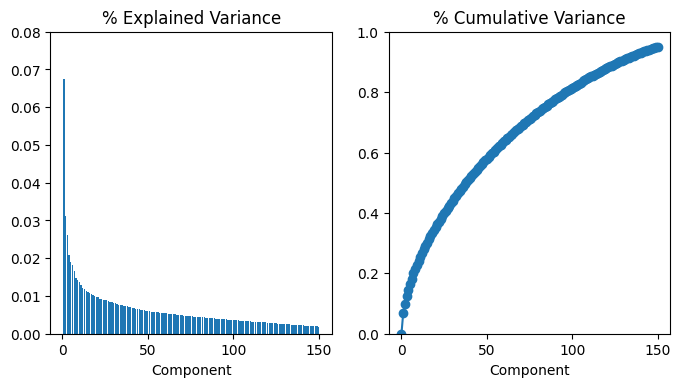

In [108]:
plot_variance(pca)

# Training with n-components of PCA

In [109]:
model5=XGBRegressor(n_estimators=400,gamma=3,subsample=0.85,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.85,n_jobs=-1)#n_estimators=400,gamma=3,subsample=0.8,learning_rate=0.09,reg_lambda=5,reg_alpha=1,max_depth=5,colsample_bytree=0.9)
model5.fit(X_train_pca,y_train)
predictions5=model5.predict(X_test_pca)

In [110]:
#model5.score(X_test_pca,y_test)

In [111]:
#model5.score(X_train_pca,y_train)

Training Score: 0.9999
Test score: 0.844

In [112]:
#mean_squared_error(y_test,predictions5)

In [113]:
#param_grid=dict(n_estimators=[200,300,400,500],gamma=[2,3,4],subsample=[0.8,0.9],learning_rate=[0.3,0.1,0.085,0.07],reg_lambda=[2,5,7],reg_alpha=[0,1,2],max_depth=[5,7,9],colsample_bytree=[0.8,0.9])
#model=XGBRegressor()
#gscv=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,scoring='neg_root_mean_squared_error',verbose=2,cv=2)

#gscv.best_estimator_

#gscv.fit(X_train_pca,y_train)

#gscv.best_estimator_

#model5=RandomForestRegressor(n_estimators=72,max_depth=9,random_state=1)
#model5.fit(X_train_imp,y_train)
#predictions5=model5.predict(X_test_imp)

#prediction5=(predictions4+predictions5)/2

# Creating Submission file

In [114]:
submission=pd.DataFrame(predictions3a,index=X_test.index)
submission.head()

,0
Id,
1461,119885.093750
1462,163816.500000
1463,179800.750000
1464,196119.171875
1465,185194.218750


In [115]:
submission=submission.reset_index()
submission.head()

,Id,0
0,1461,119885.093750
1,1462,163816.500000
2,1463,179800.750000
3,1464,196119.171875
4,1465,185194.218750


In [116]:
sample=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [117]:
submission.columns=sample.columns
submission.head()

,Id,SalePrice
0,1461,119885.093750
1,1462,163816.500000
2,1463,179800.750000
3,1464,196119.171875
4,1465,185194.218750


In [118]:
submission.to_csv('submission.csv',index=False)

In [119]:
#mean_squared_error(y_test,predictions4)

In [120]:
#model4.score(X_test_imp,y_test)

In [121]:
#predictions_train4=model4.predict(X_train_imp)
#print(mean_squared_error(y_train,predictions_train4))
#print(model4.score(X_train_imp,y_train))

In [122]:
'''model5=RandomForestRegressor(random_state=1) #n_estimators=72,max_depth=9,
model5.fit(X_train_imp,y_train)
predictions5=model5.predict(X_test_imp)

mean_squared_error(y_test,predictions5)

model5.score(X_test_imp,y_test)

predictions_train5=model5.predict(X_train_imp)
print(mean_squared_error(y_train,predictions_train5))
print(model5.score(X_train_imp,y_train))'''

'model5=RandomForestRegressor(random_state=1) #n_estimators=72,max_depth=9,\nmodel5.fit(X_train_imp,y_train)\npredictions5=model5.predict(X_test_imp)\n\nmean_squared_error(y_test,predictions5)\n\nmodel5.score(X_test_imp,y_test)\n\npredictions_train5=model5.predict(X_train_imp)\nprint(mean_squared_error(y_train,predictions_train5))\nprint(model5.score(X_train_imp,y_train))'

In [123]:
#param_grid=dict(n_estimators=[100,250,400,500],gamma=[2,3],subsample=[0.8,0.9],learning_rate=[0.3,0.1,0.09,0.07],reg_lambda=[2,5,7],reg_alpha=[0,1,2],max_depth=[5,7,9],colsample_bytree=[0.8,0.9])

#hgscv=

#gscv=GridSearchCV(estimator=XGBRegressor(),param_grid=param_grid,n_jobs=-1,scoring='neg_root_mean_squared_error',verbose=1)

#gscv.fit(X_train_imp,y_train)

#gscv.best_estimator_